## HW 2
Botasheva Zhanna

### Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm
%matplotlib inline

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# подгружаем данные
data = pd.read_csv('german_credit_data.csv')
data.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [4]:
from ydata_profiling import ProfileReport
profile = ProfileReport(data)

In [5]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Есть пропуски в признаках  `Saving accounts`, `Checking account`, заменим пропуски категориальным значением "unknow":

In [6]:
data['Saving accounts'].fillna('unknow', inplace=True)
data['Checking account'].fillna('unknow', inplace=True)

Признак `Unnamed: 0` - все значения уникальные, признаки `Duration` и `Credit amount` имеют высокую корреляцию между с собой.
Поэтому удалим столбы `Unnamed: 0` и `Credit amount`.

In [7]:
df = data.drop(columns=['Unnamed: 0', 'Credit amount'], axis=1)
df

Age     Sex  Job Housing Saving accounts Checking account  Duration  \
0     67    male    2     own          unknow           little         6   
1     22  female    2     own          little         moderate        48   
2     49    male    1     own          little           unknow        12   
3     45    male    2    free          little           little        42   
4     53    male    2    free          little           little        24   
..   ...     ...  ...     ...             ...              ...       ...   
995   31  female    1     own          little           unknow        12   
996   40    male    3     own          little           little        30   
997   38    male    2     own          little           unknow        12   
998   23    male    2    free          little           little        45   
999   27    male    2     own        moderate         moderate        45   

                 Purpose  
0               radio/TV  
1               radio/TV  
2              education  
3    furniture/equipment  
4                    car  
..                   ...  
995  furniture/equipment  
996                  car  
997             radio/TV  
998             radio/TV  
999                  car  

[1000 rows x 8 columns]

Закодируем категориальные признаки с помощью `LabelEncoder`:

In [8]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
print(categorical_columns)

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


In [9]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])
    encoders[column] = LabelEncoder()
    
df.head()

Age  Sex  Job  Housing  Saving accounts  Checking account  Duration  \
0   67    1    2        1                4                 0         6   
1   22    0    2        1                0                 1        48   
2   49    1    1        1                0                 3        12   
3   45    1    2        0                0                 0        42   
4   53    1    2        0                0                 0        24   

   Purpose  
0        5  
1        5  
2        3  
3        4  
4        1

In [10]:
df.describe()

Age          Sex          Job      Housing  Saving accounts  \
count  1000.000000  1000.000000  1000.000000  1000.000000      1000.000000   
mean     35.546000     0.690000     1.904000     1.071000         1.105000   
std      11.375469     0.462725     0.653614     0.531264         1.580023   
min      19.000000     0.000000     0.000000     0.000000         0.000000   
25%      27.000000     0.000000     2.000000     1.000000         0.000000   
50%      33.000000     1.000000     2.000000     1.000000         0.000000   
75%      42.000000     1.000000     2.000000     1.000000         2.000000   
max      75.000000     1.000000     3.000000     2.000000         4.000000   

       Checking account     Duration      Purpose  
count       1000.000000  1000.000000  1000.000000  
mean           1.577000    20.903000     2.878000  
std            1.257638    12.058814     1.978138  
min            0.000000     4.000000     0.000000  
25%            0.000000    12.000000     1.000000  
50%            1.000000    18.000000     3.000000  
75%            3.000000    24.000000     5.000000  
max            3.000000    72.000000     7.000000

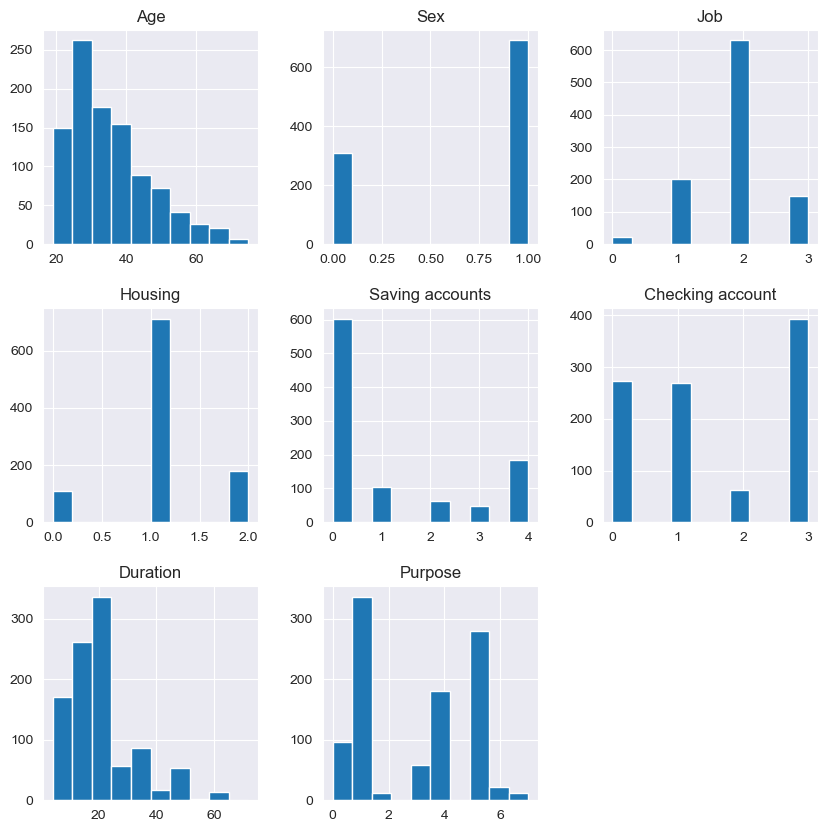

In [11]:
df.hist(figsize=(10,10));

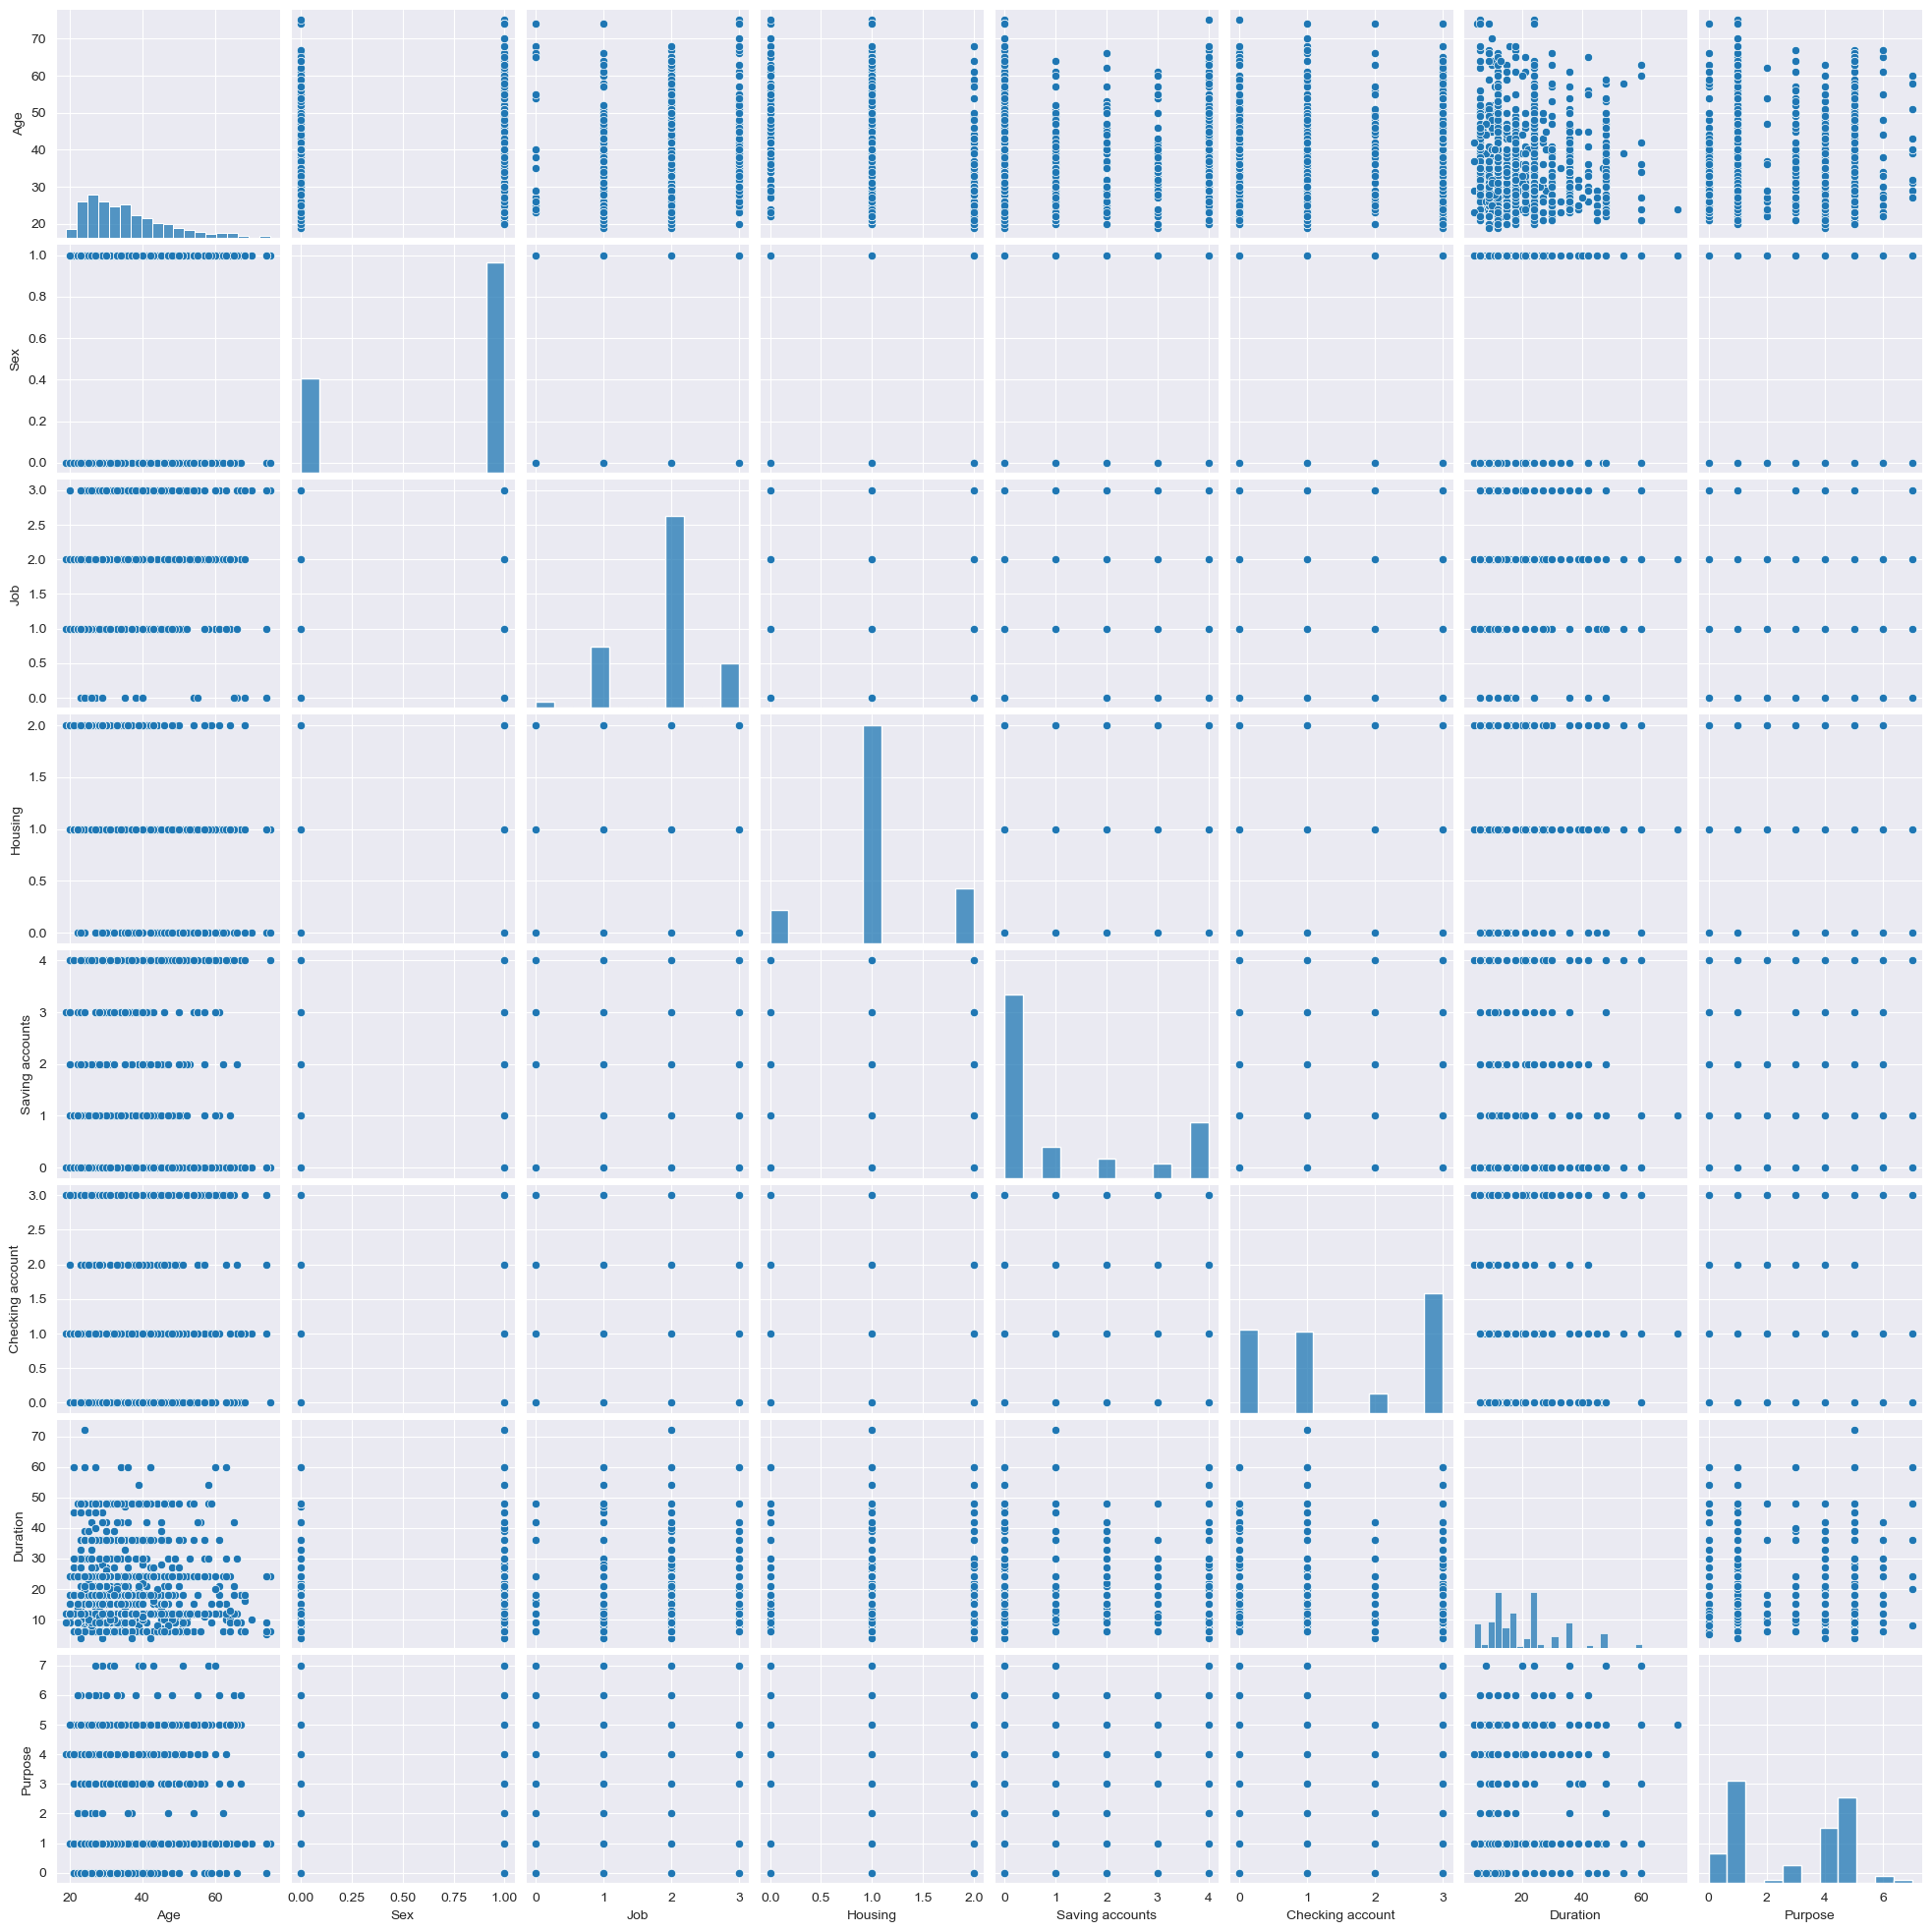

In [12]:
sns.pairplot(df);

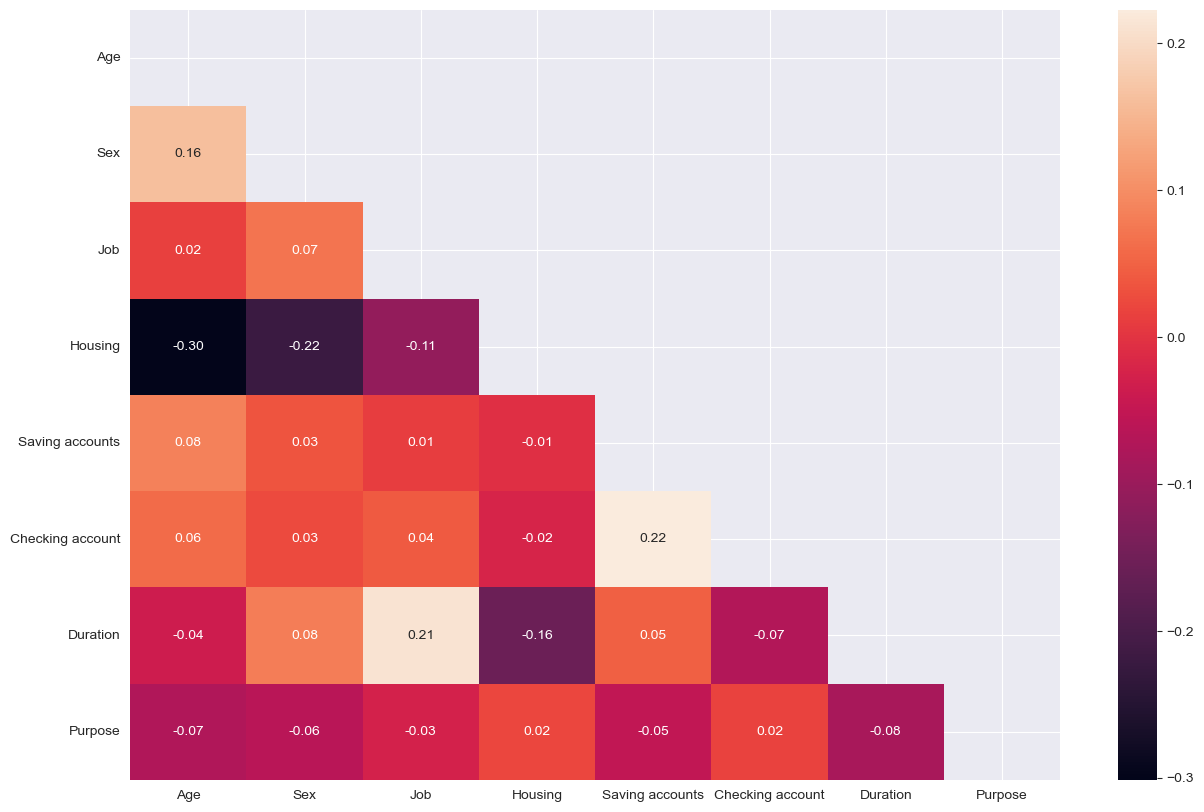

In [13]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f');

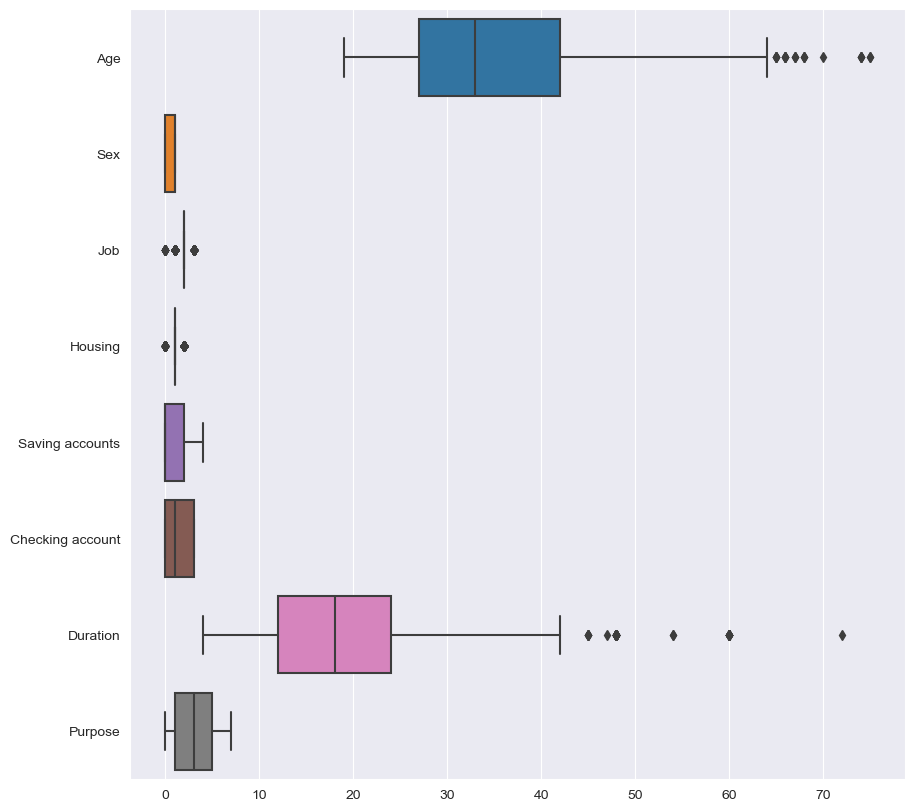

In [14]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, orient='h');

Нормалтизуем данные с помощью `MinMaxScaler`

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
df_scaled.head()

Age  Sex       Job  Housing  Saving accounts  Checking account  \
0  0.857143  1.0  0.666667      0.5              1.0          0.000000   
1  0.053571  0.0  0.666667      0.5              0.0          0.333333   
2  0.535714  1.0  0.333333      0.5              0.0          1.000000   
3  0.464286  1.0  0.666667      0.0              0.0          0.000000   
4  0.607143  1.0  0.666667      0.0              0.0          0.000000   

   Duration   Purpose  
0  0.029412  0.714286  
1  0.647059  0.714286  
2  0.117647  0.428571  
3  0.558824  0.571429  
4  0.294118  0.142857

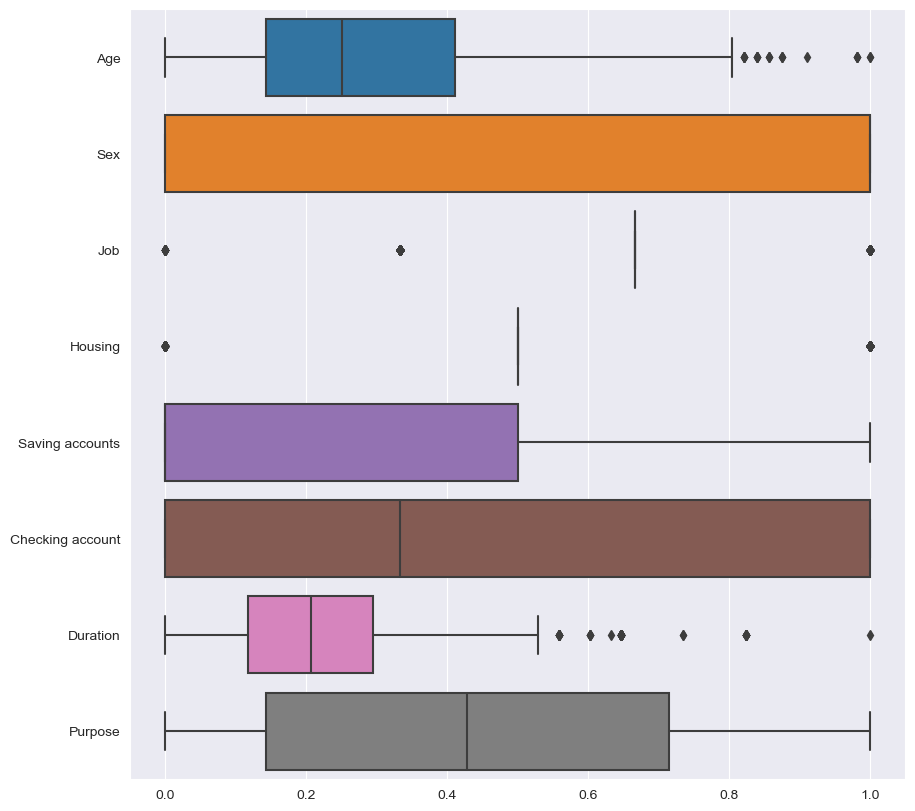

In [16]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_scaled, orient='h');

### Снижение размерности для визуализации

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

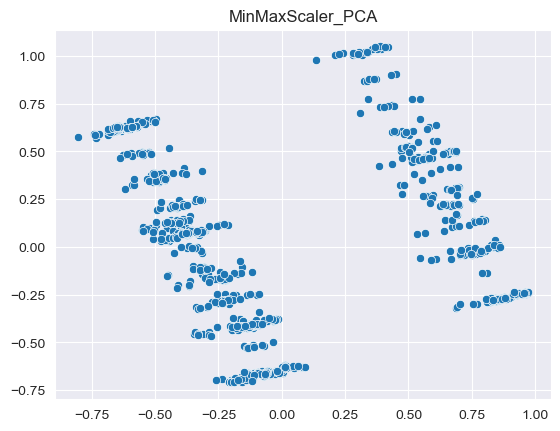

In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title('MinMaxScaler_PCA')
plt.show();

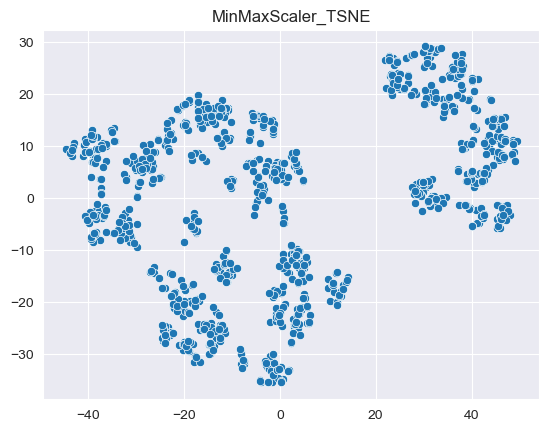

In [19]:
tsne = TSNE(n_components=2, random_state=10)
X_tsne = tsne.fit_transform(df_scaled)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1])
plt.title('MinMaxScaler_TSNE')
plt.show();

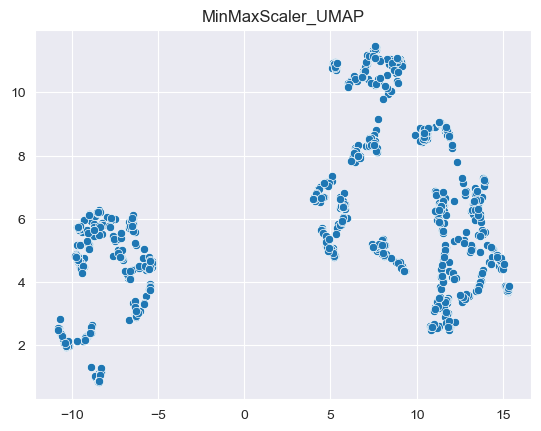

In [20]:
umap = UMAP(random_state=42)
X_umap = umap.fit_transform(df_scaled)
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1]);
plt.title('MinMaxScaler_UMAP')
plt.show();

### Независимо от варианта сжатия признакового пространства (PCA, UMAP, tSNE), видим 2 большие группы и множества подгрупп в них. Для дальнейшей работы буду использовать tSNE, так как при данном методе визуально больше подгрупп.


### K-means

In [21]:
inertia = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, random_state=10, n_init=10).fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

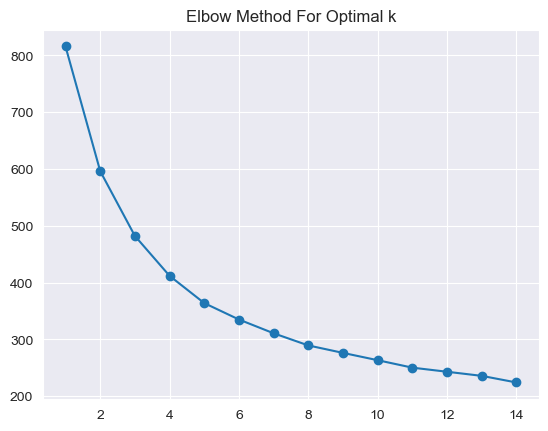

In [22]:
plt.plot(range(1,15), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
D = []
for i in range(1,13):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

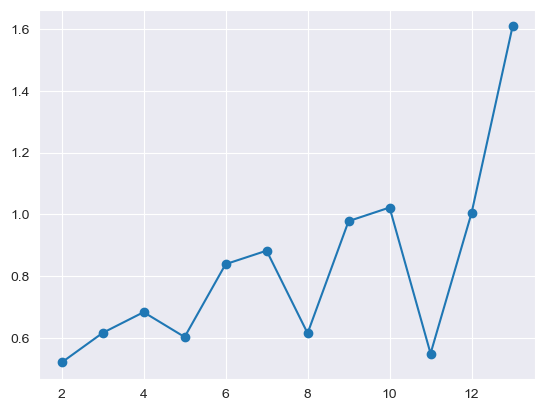

In [24]:
plt.plot(range(2,14), D, marker='o');

2 кластера

In [25]:
kmeans = KMeans(n_clusters=2, random_state=10, n_init=10).fit(df_scaled)
labels = kmeans.labels_

кластеров: 2


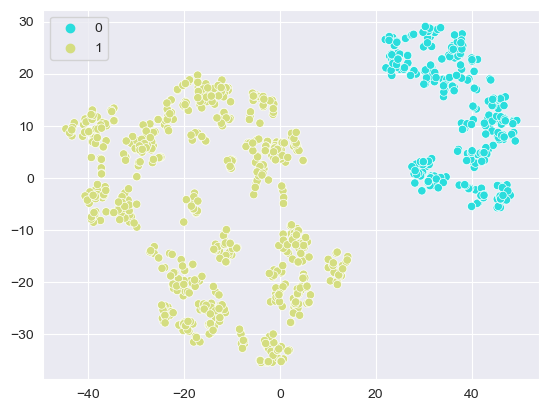

In [26]:
uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

In [27]:
df_scaled['labels'] = labels

In [28]:
df_scaled.head()

Age  Sex       Job  Housing  Saving accounts  Checking account  \
0  0.857143  1.0  0.666667      0.5              1.0          0.000000   
1  0.053571  0.0  0.666667      0.5              0.0          0.333333   
2  0.535714  1.0  0.333333      0.5              0.0          1.000000   
3  0.464286  1.0  0.666667      0.0              0.0          0.000000   
4  0.607143  1.0  0.666667      0.0              0.0          0.000000   

   Duration   Purpose  labels  
0  0.029412  0.714286       1  
1  0.647059  0.714286       0  
2  0.117647  0.428571       1  
3  0.558824  0.571429       1  
4  0.294118  0.142857       1

In [29]:
df_scaled['labels'].value_counts(normalize=True).sort_index()

labels
0    0.31
1    0.69
Name: proportion, dtype: float64

5 кластера

In [30]:
kmeans = KMeans(n_clusters=5, random_state=10, n_init=10).fit(df_scaled)
labels = kmeans.labels_

кластеров: 5


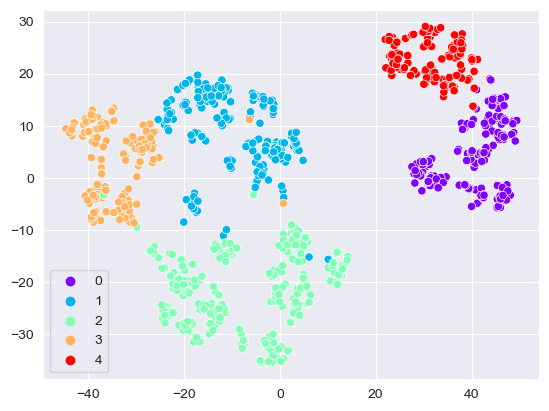

In [31]:
uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

In [32]:
df_scaled['labels'] = labels
df_scaled['labels'].value_counts(normalize=True).sort_index()

labels
0    0.174
1    0.215
2    0.311
3    0.164
4    0.136
Name: proportion, dtype: float64

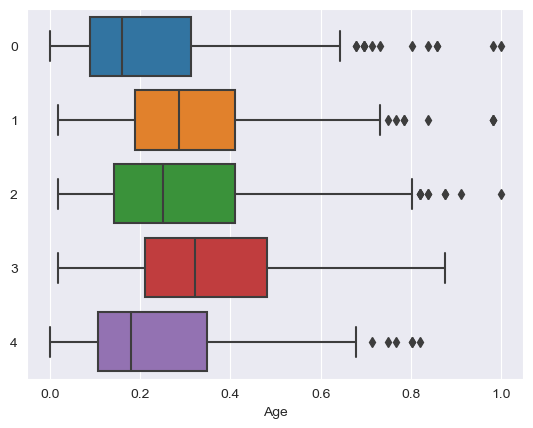

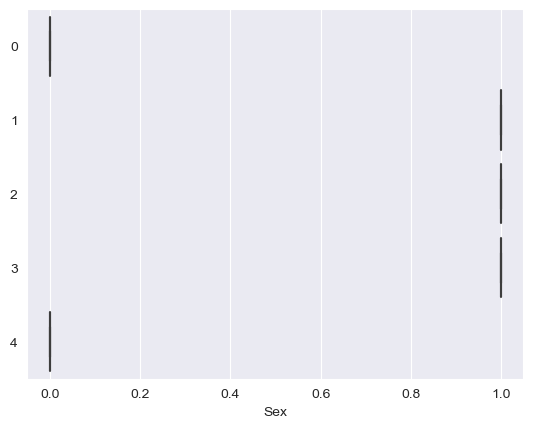

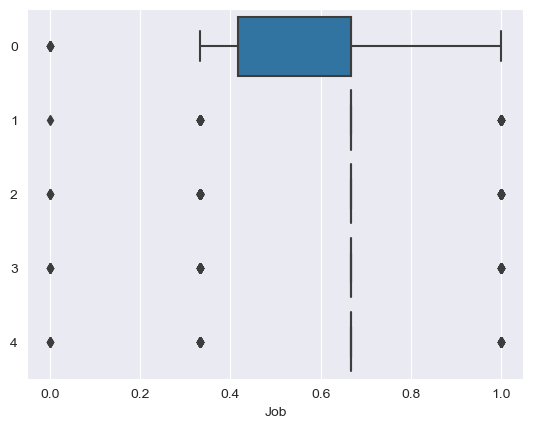

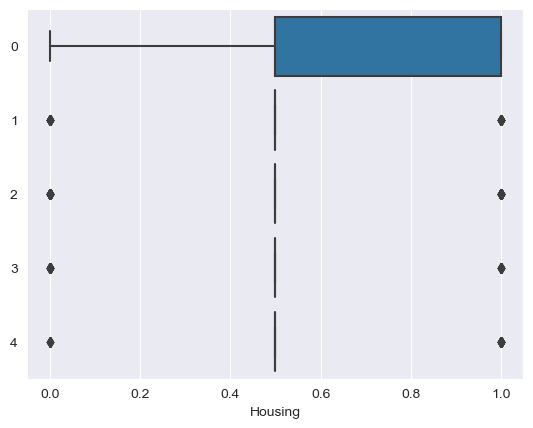

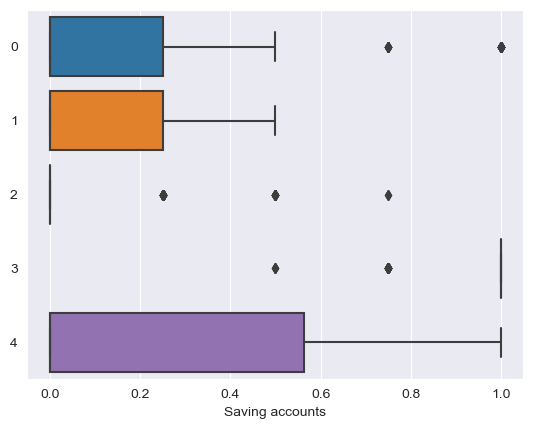

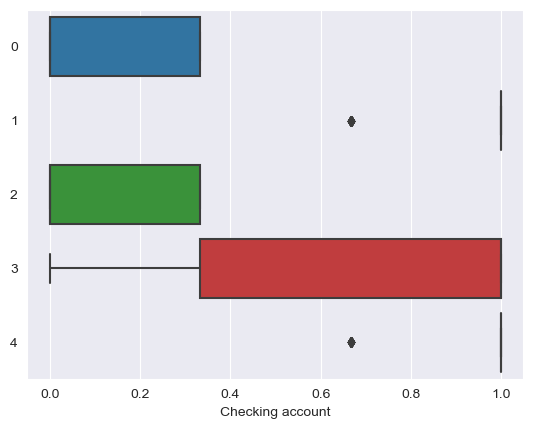

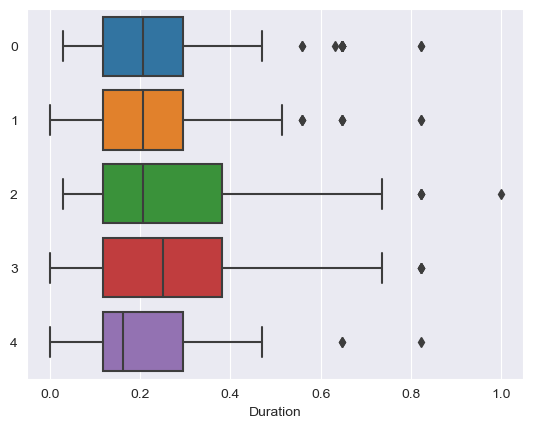

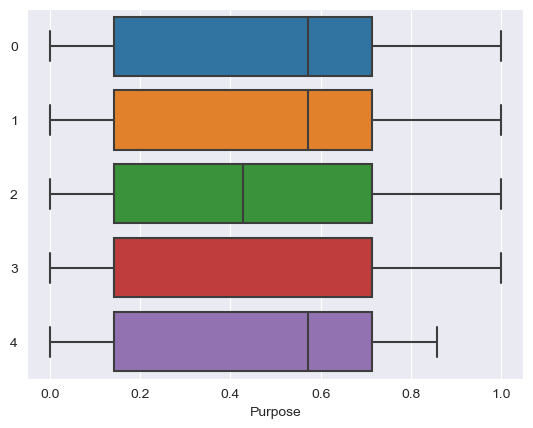

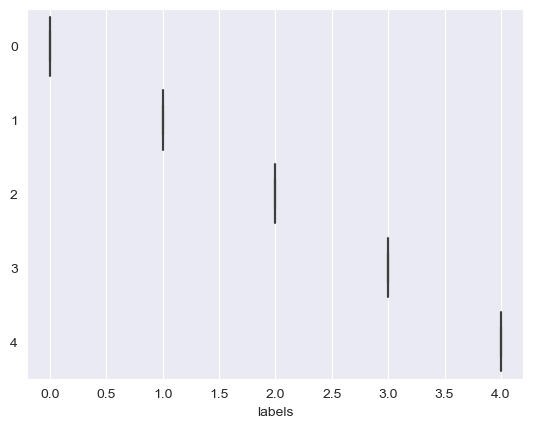

In [33]:
for col in df_scaled.columns:
    sns.boxplot(data=df_scaled, x=col, y=labels, orient='h')
    plt.show();

In [34]:
df_scaled.groupby('labels').median().T.round(2)

labels               0     1     2     3     4
Age               0.16  0.29  0.25  0.32  0.18
Sex               0.00  1.00  1.00  1.00  0.00
Job               0.67  0.67  0.67  0.67  0.67
Housing           0.50  0.50  0.50  0.50  0.50
Saving accounts   0.00  0.00  0.00  1.00  0.00
Checking account  0.00  1.00  0.00  1.00  1.00
Duration          0.21  0.21  0.21  0.25  0.16
Purpose           0.57  0.57  0.43  0.14  0.57

 ### Hierarhical 

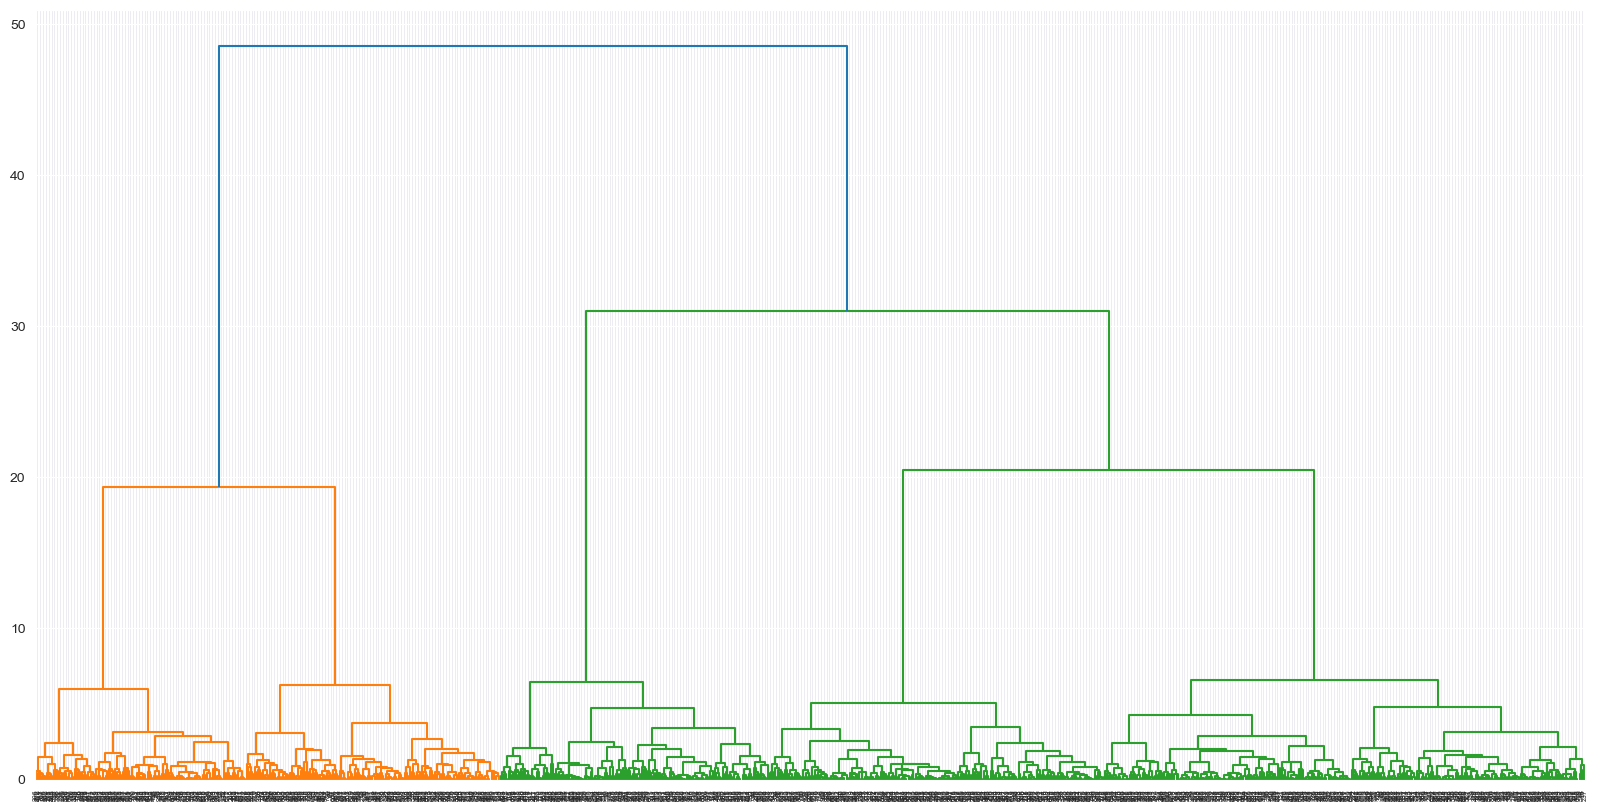

In [35]:
plt.figure(figsize=(20,10))
linkage_ = linkage(df_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

In [36]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(df_scaled)
    labels = agg.labels_
    score = silhouette_score(df_scaled, labels)
    silhouette.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.00it/s]


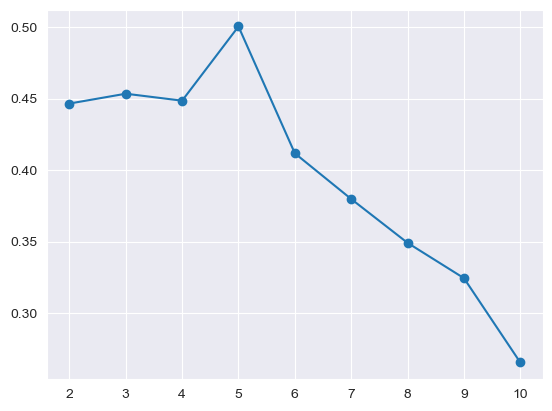

In [37]:
plt.plot(range(2,11), silhouette, marker='o');

3 кластера

кластеров: 3


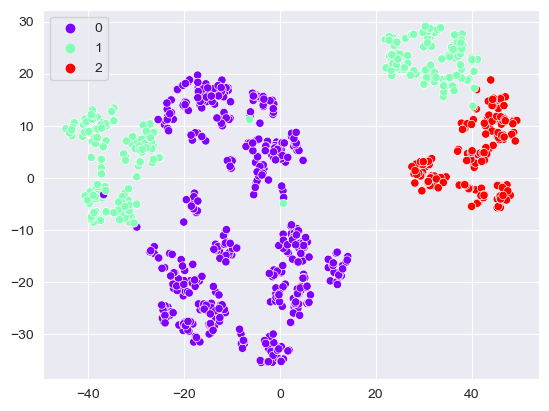

In [38]:
agg = AgglomerativeClustering(n_clusters=3).fit(df_scaled)
labels = agg.labels_

uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

In [39]:
df_scaled['labels'] = labels
df_scaled['labels'].value_counts(normalize=True).sort_index()

labels
0    0.526
1    0.300
2    0.174
Name: proportion, dtype: float64

4 кластера

кластеров: 4


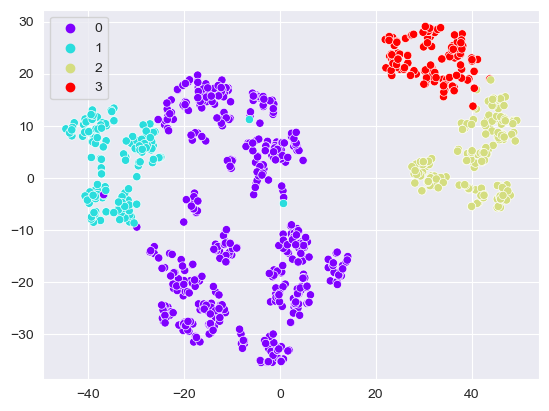

In [40]:
agg = AgglomerativeClustering(n_clusters=4).fit(df_scaled)
labels = agg.labels_

uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

In [41]:
df_scaled['labels'] = labels
df_scaled['labels'].value_counts(normalize=True).sort_index()

labels
0    0.526
1    0.164
2    0.174
3    0.136
Name: proportion, dtype: float64

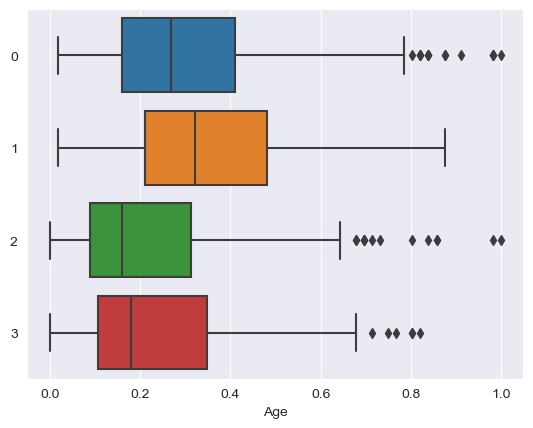

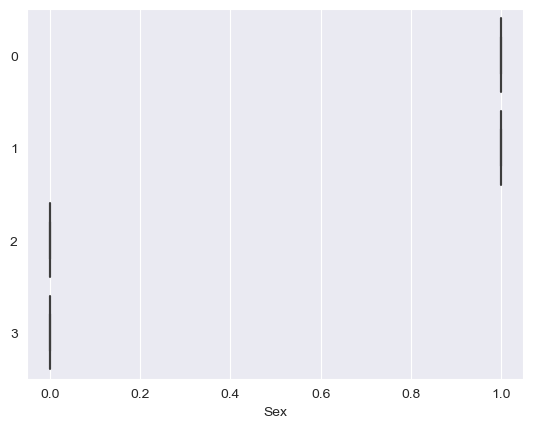

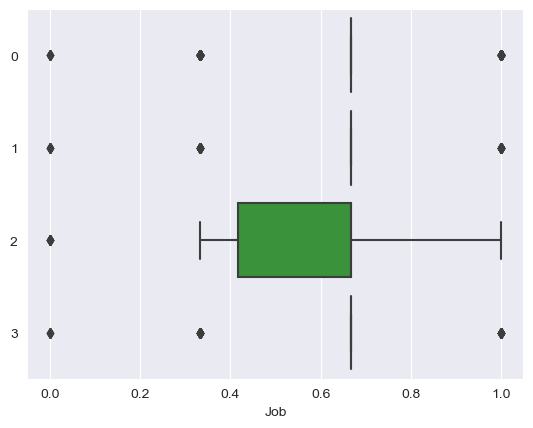

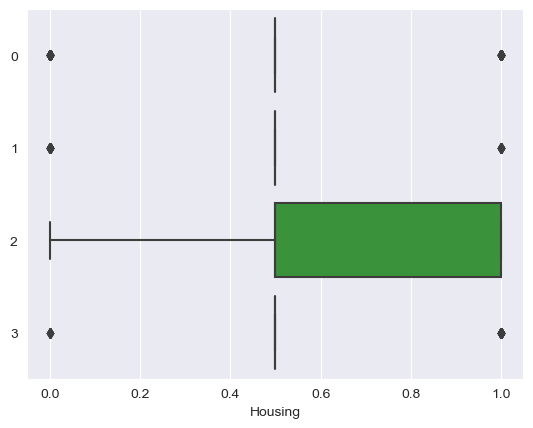

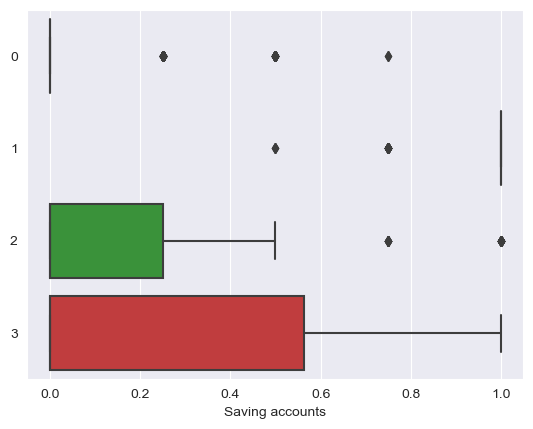

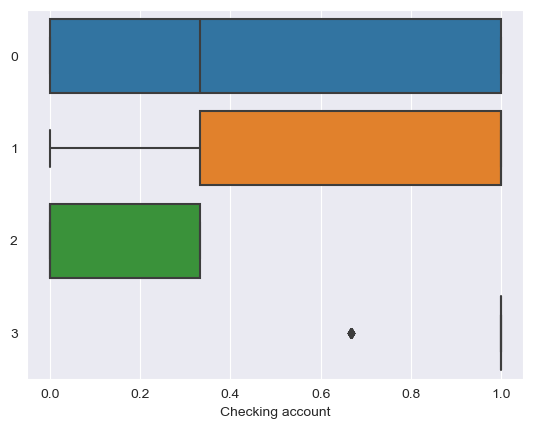

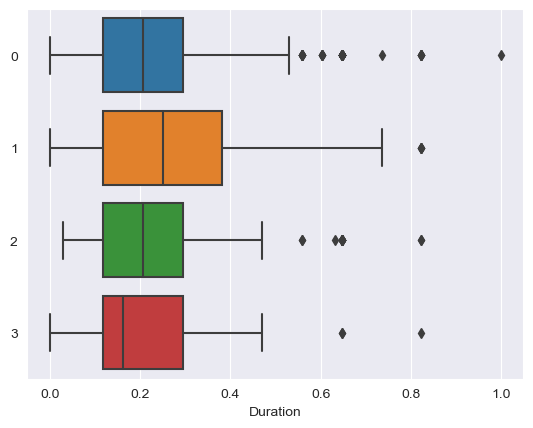

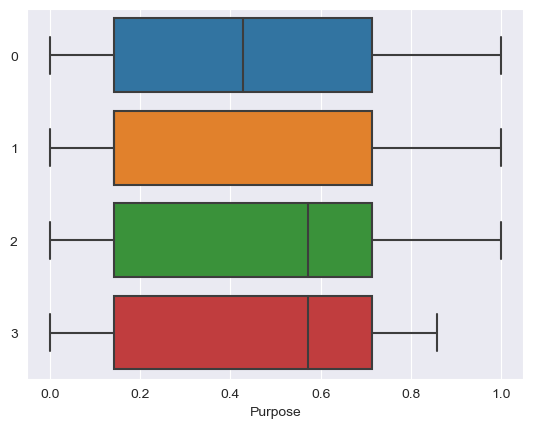

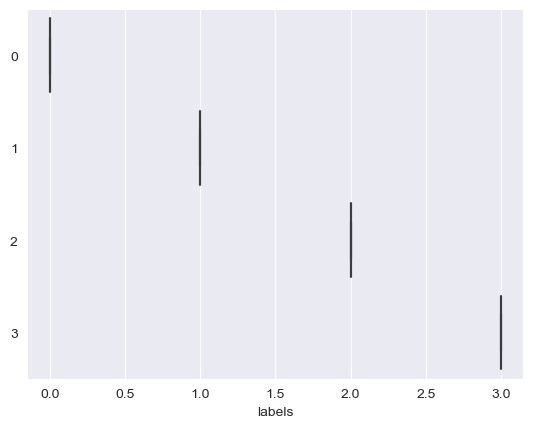

In [42]:
for col in df_scaled.columns:
    sns.boxplot(data=df_scaled, x=col, y=labels, orient='h')
    plt.show();

In [43]:
df_scaled.groupby('labels').median().T.round(2)

labels               0     1     2     3
Age               0.27  0.32  0.16  0.18
Sex               1.00  1.00  0.00  0.00
Job               0.67  0.67  0.67  0.67
Housing           0.50  0.50  0.50  0.50
Saving accounts   0.00  1.00  0.00  0.00
Checking account  0.33  1.00  0.00  1.00
Duration          0.21  0.25  0.21  0.16
Purpose           0.43  0.14  0.57  0.57

### DBSCAN

In [44]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.17it/s]


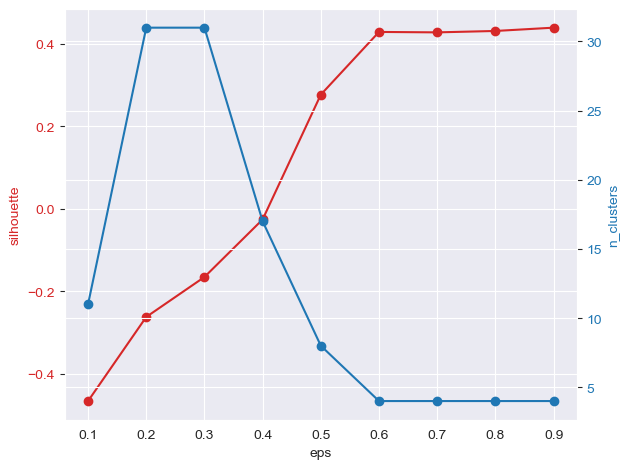

In [45]:
eps_range = np.arange(0.1,1,0.1)
dbscan_clustering(eps_range, df_scaled)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.21it/s]


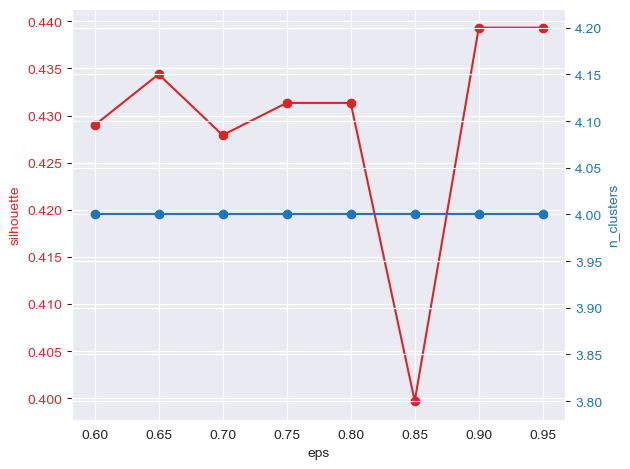

In [46]:
eps_range = np.arange(0.6,1,0.05)
dbscan_clustering(eps_range, df_scaled)

In [47]:
dbscan = DBSCAN(eps=0.65, min_samples=5).fit(df_scaled)
labels = dbscan.labels_
plot_data = pd.DataFrame(zip(X_tsne[:,0], X_tsne[:,1], labels), columns=['x', 'y', 'hue'])

кластеров: 4


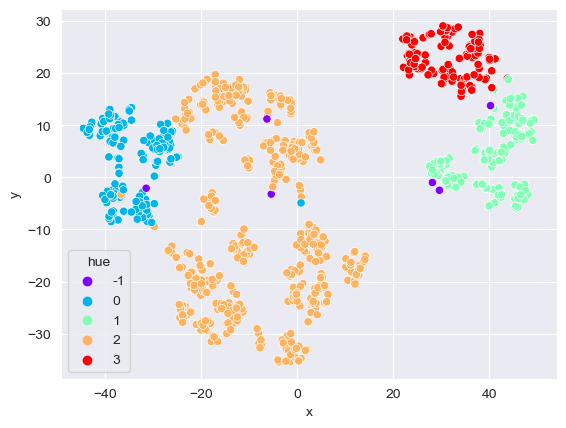

In [48]:
uniq_labels = np.unique(labels)
n_clusters = len(uniq_labels[uniq_labels != -1])
print(f'кластеров: {n_clusters}')
sns.scatterplot(plot_data, x='x', y='y', hue='hue', palette='rainbow');

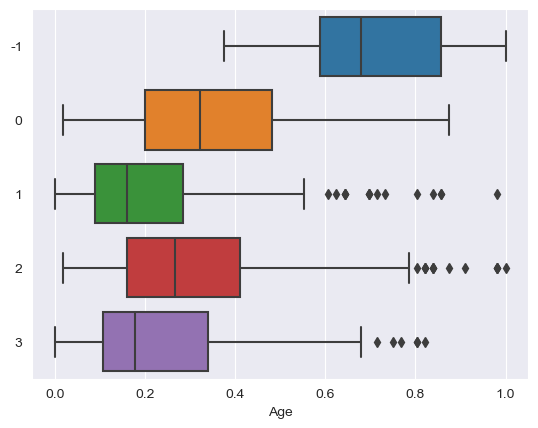

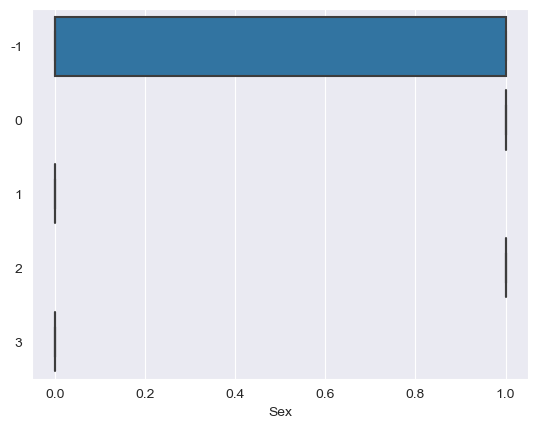

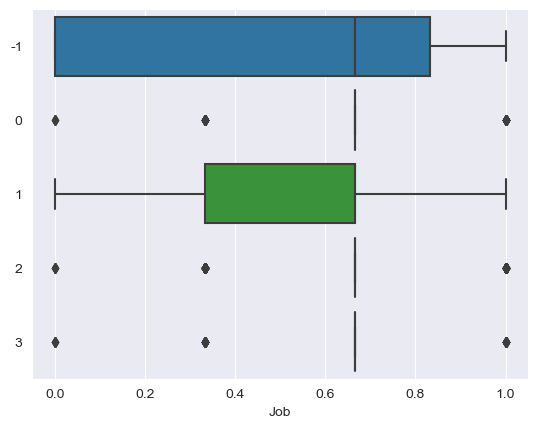

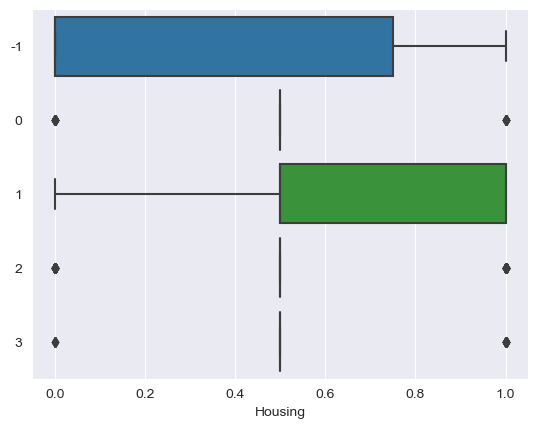

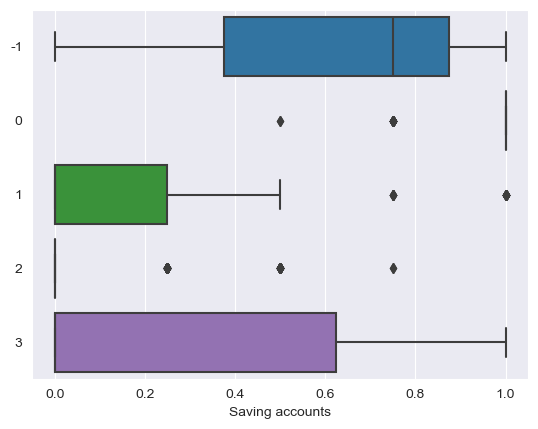

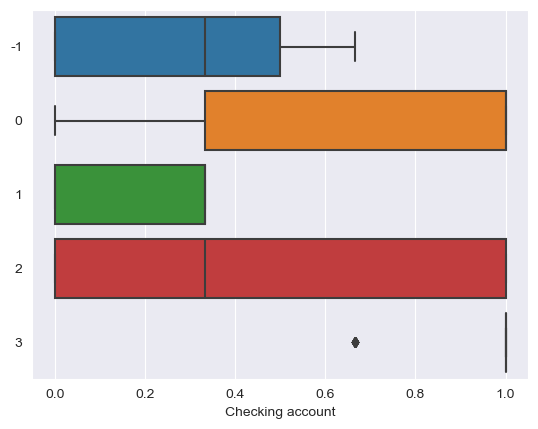

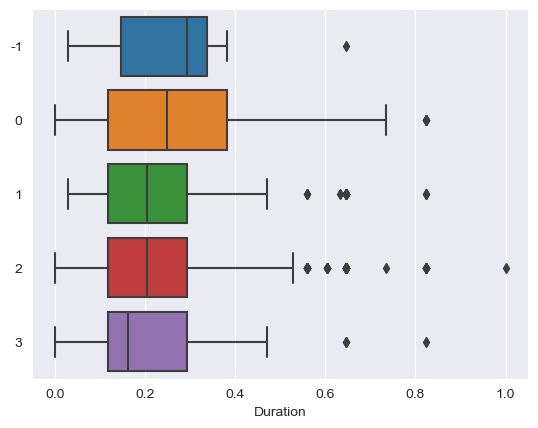

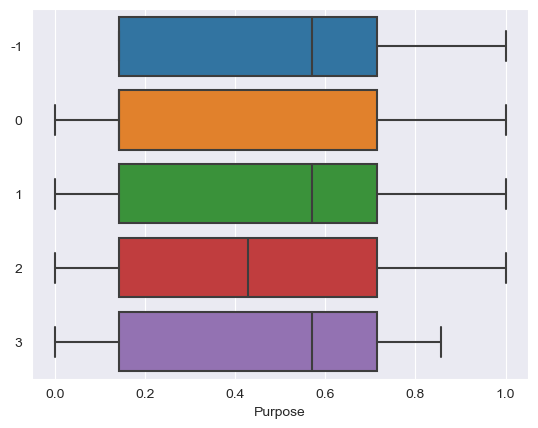

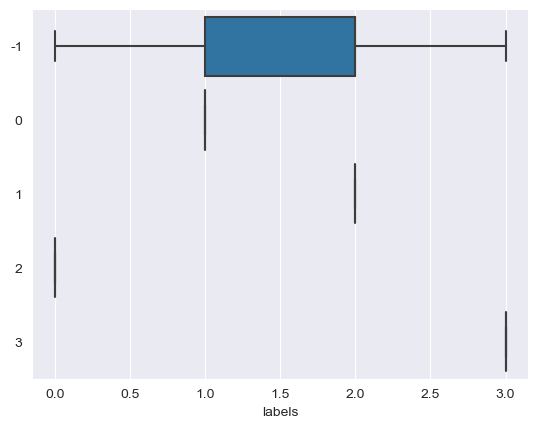

In [49]:
for col in df_scaled.columns:
    sns.boxplot(data=df_scaled, x=col, y=labels, orient='h')
    plt.show();

In [50]:
df_scaled.groupby('labels').median().T.round(2)

labels               0     1     2     3
Age               0.27  0.32  0.16  0.18
Sex               1.00  1.00  0.00  0.00
Job               0.67  0.67  0.67  0.67
Housing           0.50  0.50  0.50  0.50
Saving accounts   0.00  1.00  0.00  0.00
Checking account  0.33  1.00  0.00  1.00
Duration          0.21  0.25  0.21  0.16
Purpose           0.43  0.14  0.57  0.57

Независимо от метода кластеризации:
* группы строго разбиты по признаку `Sex`, что вполне логично;
* медианы признаков `Job`, `Housing` получились одинаковые, можно было бы попробовать убрать данные признаки и кластеризовать;
* возможно стоит больше внимания уделить признакам `Age`,`Duration`, `Purpose`